In [1]:
#importing libraries
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
#Extracting EgoNode- 686
fb_df = pd.read_csv('data/686.edges',sep=" ", header = None,names=["node_1", "node_2"])
fb_df.head()

,node_1,node_2
0,827,819
1,830,826
2,828,752
3,756,694
4,828,728


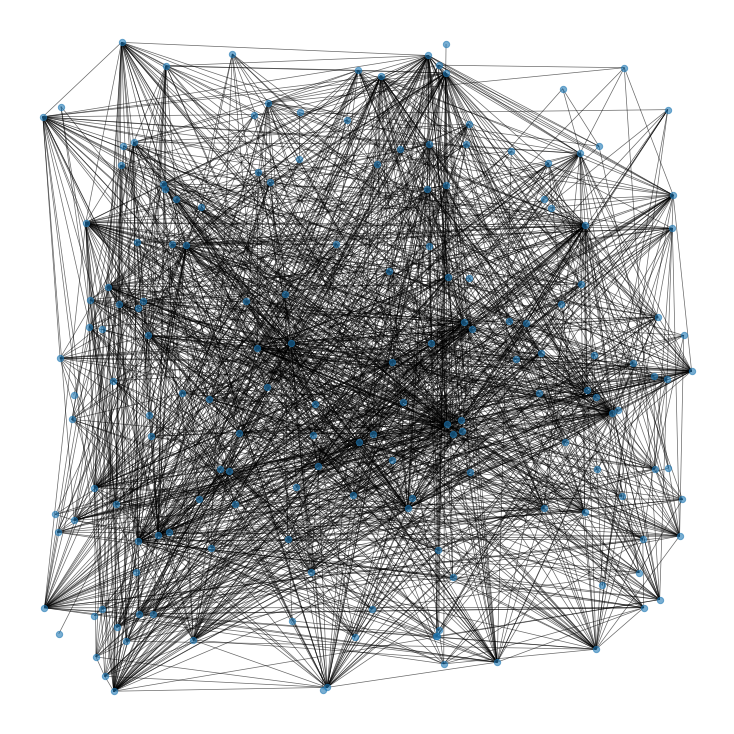

In [3]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [4]:
#Analyzing graph
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 168
Number of edges: 1656
Average degree:  19.7143


In [5]:
fb_df=nx.to_pandas_edgelist(G,source='node_1',target='node_2')

In [6]:
fb_df.shape

(1656, 2)

In [7]:
#creating adjacency matrix
node_list=list(G.nodes)
adj_G = nx.to_numpy_matrix(G)

In [8]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse node_list
offset = 0
for i in node_list:
  for j in node_list:        
        if i != j:          
            if(G.has_edge(i,j) == False):
              all_unconnected_pairs.append([i,j])    

  node_list.remove(i)    

In [9]:
#number of unconnected pairs
len(all_unconnected_pairs)

9236

In [10]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

# creating dataframe of all unconnected pairs
data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [11]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|█████████████████████████████████████████████████████████████████████████████| 1656/1656 [00:06<00:00, 243.05it/s]


In [12]:
#number of omissible links
len(omissible_links_index)

1489

In [13]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [14]:
data['link'].value_counts()

0    9236
1    1489
Name: link, dtype: int64

In [15]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [16]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

unable to import 'smart_open.gcs', disabling that module
Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.83it/s]


In [17]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

c:\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [18]:
#splitting data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [19]:
#fitting data to LogisticRegression model
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

c:\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
#calculating probablity of links
predictions = lr.predict_proba(xtest)

In [21]:
#evaluating the model
roc_auc_score(ytest, predictions[:,1])

0.7737496669092759

In [25]:
#get indices of pairs with probablity of forming a link greater than 0.80
ans_index=[]
x=0
for i in ytest:
    
    if(i==0):
        if(predictions[x,1]>0.90):
            ans_index.append(x)
    x+=1

In [26]:
#add all pairs to a list
ans=[]
for i in ans_index:
    temp=[]
    temp.append(data['node_1'].iloc[i])
    temp.append(data['node_2'].iloc[i])
    ans.append(temp)

In [27]:
#Link Prediction
ans

[[827, 711], [764, 799], [844, 821], [702, 770], [732, 709]]